In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from olist.data import Olist
from olist.order import Order
from olist.seller import Seller

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [34]:
#geting tables
orders = Order().get_training_data(with_distance_seller_customer=True).copy()
data = Olist().get_data().copy()
matching_table = Olist().get_matching_table().copy()
seller=Seller().get_training_data().copy()
order_review=data['order_reviews']
order_review=order_review.merge(matching_table[['order_id','seller_id']], how='left', on='order_id')

# Explore

<AxesSubplot:xlabel='sales', ylabel='share_of_one_stars'>

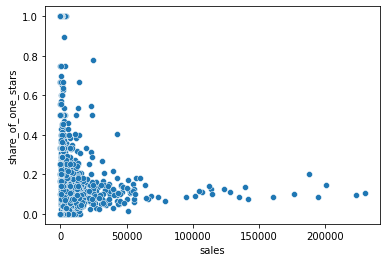

In [33]:
#investigate sales vs share of one star
sns.scatterplot(x=seller['sales'],y=seller['share_of_one_stars'])

# OLIST cummulative financials

In [15]:
seller['cumm_costs_total']=seller['monthly_costs_total']*seller['months_of_sales']

In [16]:
seller['cumm_profit']=seller['sales']-seller['cumm_costs_total']

In [17]:
seller=seller.sort_values(by=['monthly_profit'], ascending=False)

In [18]:
sorted_sellers=seller.reset_index()

## Contribution of each seller on profit

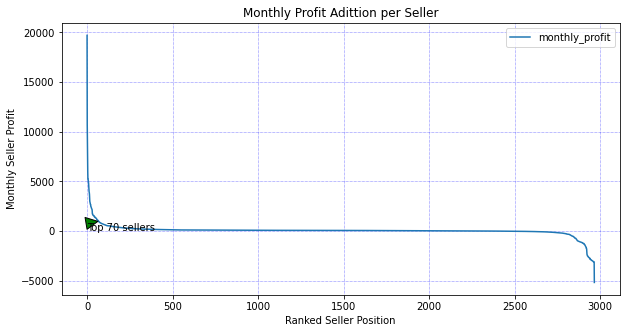

In [33]:
### Total Olist Profit
fig, ax1 = plt.subplots(figsize=(10,5))
profit_seller= sns.lineplot(data=sorted_sellers[['monthly_profit']])
profit_seller.set(xlabel='Ranked Seller Position', ylabel='Monthly Seller Profit')
profit_seller.set_title('Monthly Profit Adittion per Seller')
profit_seller.grid(linestyle=':', linewidth='0.5', color='blue')

profit_seller.annotate('Top 70 sellers', xy =(70, 1000),
             xytext =(3, 1.8),
             arrowprops = dict(facecolor ='green',
                               shrink = 0.1),   )
#profit_seller.annotate('70', xy =(3000, 1000),
#            xytext =(2200, 3),
#            arrowprops = dict(facecolor ='red',
#                              shrink = 0.1),   )
plt.show(profit_seller)

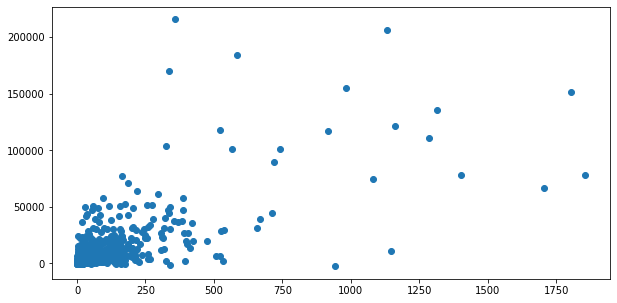

In [100]:
fig, ax3 = plt.subplots(figsize=(10,5))
ax3.scatter(sorted_sellers['n_orders'],sorted_sellers['cumm_profit'])

In [64]:
tier_1=sorted_sellers[:71]
tier_3=sorted_sellers[sorted_sellers['monthly_profit']<0]
tier_2=sorted_sellers[71:(sorted_sellers.shape[0]-tier_3.shape[0])]

# Profit Drainers - Let's Analyze the negative tail of the profit curve

In [36]:
negative_profit=sorted_sellers[sorted_sellers['cumm_profit']<0]

Text(0, 0.5, 'profit loss')

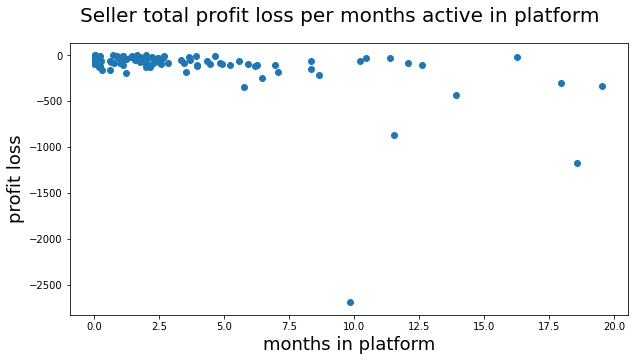

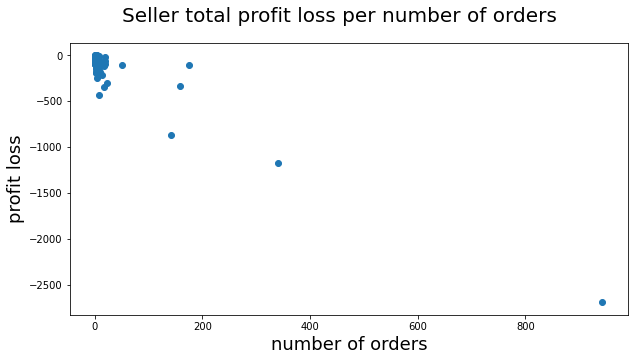

In [46]:
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.scatter(negative_profit['months_of_sales'],negative_profit['cumm_profit'])
fig1.suptitle('Seller total profit loss per months active in platform', fontsize=20)
plt.xlabel('months in platform', fontsize=18)
plt.ylabel('profit loss', fontsize=18)


fig2, ax2 = plt.subplots(figsize=(10,5))
ax2.scatter(negative_profit['n_orders'],negative_profit['cumm_profit'])
fig2.suptitle('Seller total profit loss per number of orders', fontsize=20)
plt.xlabel('number of orders', fontsize=18)
plt.ylabel('profit loss', fontsize=18)

**Conclusion**: Sellers that have been in the platform for longer periods of time have higher loss than the newly joined in the platform.
We can call them "persistent profit drainers" meaning we dont believe they can improve their performance and will be excluded from sales platform.

**We define a forgiving period of 3 months so the newly joined seller can adapt and adjust their operation. After 3months, any operation that result in profit loss will be shut down.**

### Add seller id to order reviews

In [158]:
boolean_series = order_review.seller_id.isin(sellerid_list)

In [159]:
review_neg_sellers=order_review[boolean_series]

In [160]:
review_neg_sellers=review_neg_sellers[review_neg_sellers['review_score']<3]

In [162]:
review_neg_sellers

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,seller_id
56,e233e51d11511bf30e568c76360ace52,548df2c6e5f089574614894bca78acf5,1,NaN,recebi somente 1 controle Midea Split ESTILO.\...,2018-01-28 00:00:00,2018-02-04 11:06:15,8b321bb669392f5163d04c59e235e066
234,3ff8285931cc9b54c9ad22ba78957f63,e6b23db78d4473c921fb9315e04b5c0f,1,NaN,Comprei dois produtos e recebi somente um. Man...,2017-05-14 00:00:00,2017-05-19 10:38:27,c1d1ebb4745cc43cb6f05e9c8a705c9a
493,7e6becdbaed9bd20e60602d1f8c2b4f9,acf6e912a8db79e50ddd2fe14628e89c,1,NaN,NaN,2018-08-15 00:00:00,2018-08-15 21:08:00,08ad4ac1388e4420ca531c3edfc46198
525,8fa0fe324426c676a8989ec7815a036c,7758cf0b4302587a9628d90b58d56dd8,1,NaN,NaN,2017-03-23 00:00:00,2017-03-23 18:31:14,b76dba6c951ab00dc4edf0a1aa88037e
725,2165b2b26e67eee7a9d28e13c0ad0468,d2aefa1e404936eb9c5660ac2bde4ecb,1,NaN,Não recebi o produto.e agora?,2018-05-30 00:00:00,2018-05-30 03:19:24,8b321bb669392f5163d04c59e235e066
...,...,...,...,...,...,...,...,...
103627,63fe749565f3523c3315875954399273,d71fc3033bc27e81b5a946294eb577dc,2,NaN,Comprei o espeto flex e o estinho flex.\r\no E...,2017-08-26 00:00:00,2017-08-29 10:54:54,2ec6e37d992a95eaddb3369dcbcc76d9
103647,96b865b772077a824d10f17724456947,79617f3124fcf7a760316d99421bd30f,1,NaN,NaN,2018-02-10 00:00:00,2018-02-11 11:36:11,6f1a1263039c76e68f40a8e536b1da6a
103862,054489c42e7a42ac12e216c7e5d63877,93c6619a4bcc406da04323380c97d896,1,NaN,ja estou esperando a um mês e não recebi o pro...,2018-03-07 00:00:00,2018-03-07 11:20:55,8b321bb669392f5163d04c59e235e066
104013,4605c29e0e3bf16ddc99db82aac244f6,f83b35bc0a9c439bc1a4a6597f425432,1,NaN,NaN,2018-01-17 00:00:00,2018-01-18 00:15:24,92eb0f42c21942b6552362b9b114707d


# Tier 3 - sellers negative profit

In [49]:
monthly_loss=tier_3['monthly_profit'].sum()

### average monthly loss of -253 048 RS

In [50]:
senior_sellers_tier_3=tier_3[tier_3['months_of_sales']>3]

In [51]:
new_sellers_tier_3=tier_3[tier_3['months_of_sales']<=3]

In [55]:
persis_loss_ratio=senior_sellers_tier_3['monthly_profit'].sum()/monthly_loss

We have an average monthly loss of 253k from the profit drainers sellers. By terminating the persistent ones, ie, the ones who have been in the platform for more than 3 months, we will reduce by 40k a month.
Its a 16% reduction.

But we need to coach the remaining freshly new joiners so they don't become persistent profit drainers.

## Let's analyze why they are having losses:

In [78]:
wait_time_new_sellers=new_sellers_tier_3['wait_time'].mean()
wait_time_tier1=tier_1['wait_time'].mean()

/home/louisedantas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/louisedantas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='wait_time', ylabel='Density'>

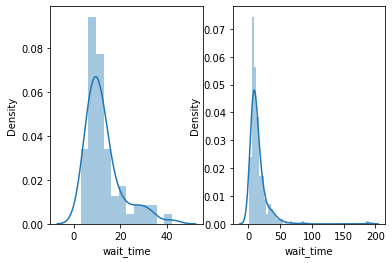

In [84]:
fig, ax =plt.subplots(1,2)
sns.distplot(tier_1['wait_time'],ax=ax[0])
sns.distplot(new_sellers_tier_3['wait_time'],ax=ax[1])

In [88]:
tier_1[tier_1['delay_to_carrier']>0]['delay_to_carrier']

11     4.858067
13    12.695567
21     1.093530
23     0.153472
30    18.517870
61    15.268524
65     0.530509
68     7.119236
69     5.294271
Name: delay_to_carrier, dtype: float64

<AxesSubplot:xlabel='delay_to_carrier'>

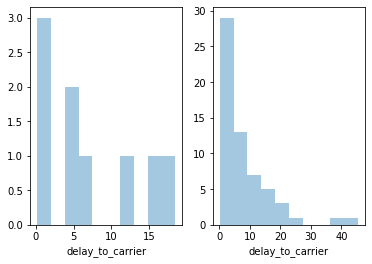

In [234]:
fig, ax =plt.subplots(1,2)
sns.distplot(tier_1[tier_1['delay_to_carrier']>0]['delay_to_carrier'],ax=ax[0],kde=False,bins=10)
sns.distplot(new_sellers_tier_3[new_sellers_tier_3['delay_to_carrier']>0]['delay_to_carrier'],ax=ax[1],kde=False,bins=10)

### Reviews os newly joined sellers

In [93]:
new_seller_list=new_sellers_tier_3['seller_id'].tolist()
boolean_series = order_review.seller_id.isin(new_seller_list)
review_neg_sellers=order_review[boolean_series]

In [227]:
pd.options.display.max_colwidth=300
#review_neg_sellers[review_neg_sellers['review_score']<3][['review_comment_message']].dropna().tail(60)

In [150]:
review_neg_sellers['cancel']=review_neg_sellers['review_comment_message'].str.contains("cancel", case=False)
review_neg_sellers['different']=review_neg_sellers['review_comment_message'].str.contains("errad|difere|veio outro|veio outra", case=False)
review_neg_sellers['delay']=review_neg_sellers['review_comment_message'].str.contains("demora|atras", case=False)
review_neg_sellers['never arrived']=review_neg_sellers['review_comment_message'].str.contains("não receb|não chegou|nao receb|nao chegou|não entreg|nao entreg|nao foi entreg|não foi entreg", case=False)
review_neg_sellers['counterfeit']=review_neg_sellers['review_comment_message'].str.contains("original|falso|falsificado", case=False)
review_neg_sellers['incomplete']=review_neg_sellers['review_comment_message'].str.contains("incomplet|imcomplet|recebi apenas|faltando|chegou apenas|só recebi|so recebi", case=False)

/tmp/ipykernel_8508/3217303109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_neg_sellers['cancel']=review_neg_sellers['review_comment_message'].str.contains("cancel", case=False)
/tmp/ipykernel_8508/3217303109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_neg_sellers['different']=review_neg_sellers['review_comment_message'].str.contains("errad|difere|veio outro|veio outra", case=False)
/tmp/ipykernel_8508/3217303109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a co

In [151]:
perc_cancel=review_neg_sellers[review_neg_sellers['review_score']<3]['cancel'].sum()/review_neg_sellers[review_neg_sellers['review_score']<3].shape[0]
perc_diff=review_neg_sellers[review_neg_sellers['review_score']<3]['different'].sum()/review_neg_sellers[review_neg_sellers['review_score']<3].shape[0]
perc_never_arrived=review_neg_sellers[review_neg_sellers['review_score']<3]['never arrived'].sum()/review_neg_sellers[review_neg_sellers['review_score']<3].shape[0]
perc_counterfeit=review_neg_sellers[review_neg_sellers['review_score']<3]['counterfeit'].sum()/review_neg_sellers[review_neg_sellers['review_score']<3].shape[0]
perc_delay=review_neg_sellers[review_neg_sellers['review_score']<3]['delay'].sum()/review_neg_sellers[review_neg_sellers['review_score']<3].shape[0]
perc_incomplete=review_neg_sellers[review_neg_sellers['review_score']<3]['incomplete'].sum()/review_neg_sellers[review_neg_sellers['review_score']<3].shape[0]

In [200]:
print(f"Orders that never arrived: {int(perc_never_arrived*100)}% \nOrders canceled: {int(perc_cancel*100)}% \nOrders delayed: {int(perc_delay*100)}% \nWrong goods received: {int(perc_diff*100)}% \nGoods are counterfeit: {int(perc_counterfeit*100)}% \nOrder received incomplete:{int(perc_incomplete*100)}%")

Orders that never arrived: 21% 
Orders canceled: 3% 
Orders delayed: 6% 
Wrong goods received: 6% 
Goods are counterfeit: 2% 
Order received incomplete:9%


### Investigate orders that never arrived:

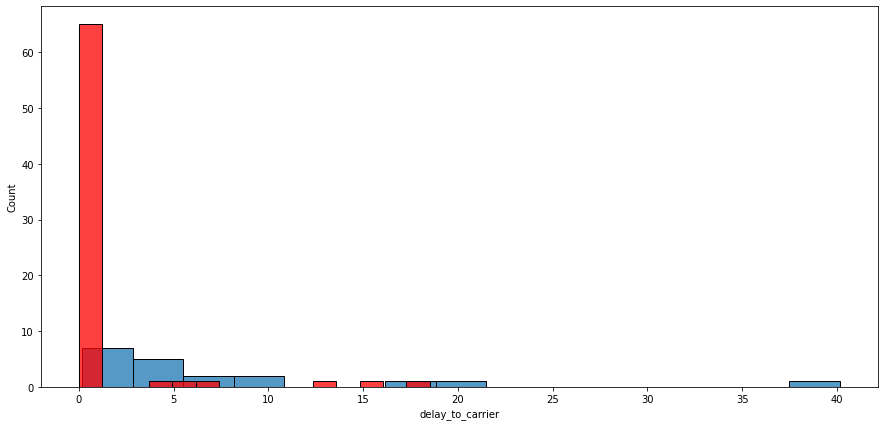

<Figure size 1080x504 with 0 Axes>

In [240]:
seller_never_arrived=review_neg_sellers[review_neg_sellers['never arrived']==True]['seller_id'].tolist()
boolean_series = new_sellers_tier_3.seller_id.isin(seller_never_arrived)
plt.figure(figsize=(15,7))
sns.histplot(new_sellers_tier_3[boolean_series][new_sellers_tier_3[boolean_series]['delay_to_carrier']>0]['delay_to_carrier'],bins=15)
sns.histplot(tier_1['delay_to_carrier'],color='red',bins=15)
plt.figure(figsize=(15,7))
plt.show()

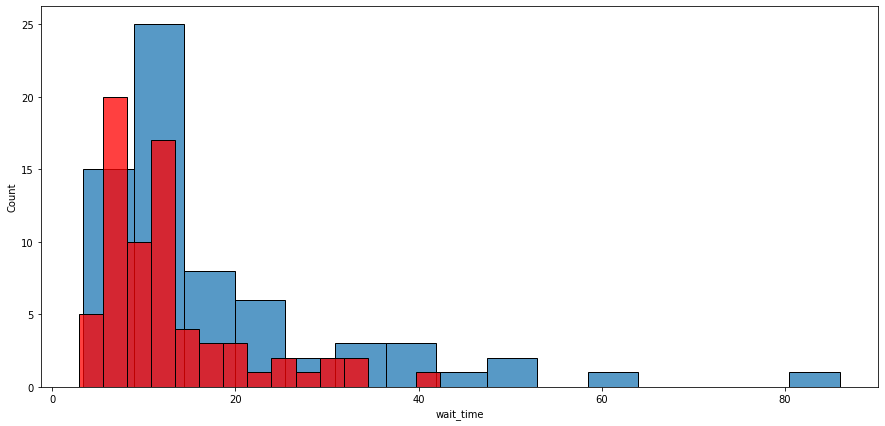

In [241]:
seller_never_arrived=review_neg_sellers[review_neg_sellers['never arrived']==True]['seller_id'].tolist()
boolean_series = new_sellers_tier_3.seller_id.isin(seller_never_arrived)
plt.figure(figsize=(15,7))
sns.histplot(new_sellers_tier_3[boolean_series][new_sellers_tier_3[boolean_series]['wait_time']>0]['wait_time'],bins=15)
sns.histplot(tier_1['wait_time'],color='red',bins=15)
plt.show()

# Tier 2

# Tier 1